In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym 
from gymnasium import spaces
from stable_baselines3 import PPO
from scipy.optimize import linprog
import seaborn as sns
#Avoid kernel dead(Use chatGPT to solve this problem)
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [ ]:
# Load datasets
file_path_2 = r"C:\Users\jerry\Desktop\UOA Project\B\Data\ModifiedCallCenterTwo.xlsx" 

df2 = pd.read_excel(file_path_2, sheet_name="Sheet1") 
df2.head() 


,Call Id,Agent,Date,Time,Topic,Answered (Y/N),Resolved,Speed of answer in seconds,AvgTalkDuration,Satisfaction rating
0,ID0001,Sarah,2021-01-01,09:12:58,Contract related,Y,Y,109.0,00:02:23,3.0
1,ID0002,Sarah,2021-01-01,09:12:58,Technical Support,Y,N,70.0,00:04:02,3.0
2,ID0003,Sarah,2021-01-01,09:47:31,Contract related,Y,Y,10.0,00:02:11,3.0
3,ID0004,Sarah,2021-01-01,09:47:31,Contract related,Y,Y,53.0,00:00:37,2.0
4,ID0005,Sarah,2021-01-01,10:00:29,Payment related,Y,Y,95.0,00:01:00,3.0



Analysis for Small 2-Agent Dataset:
       Speed of answer in seconds  Satisfaction rating
count                 4054.000000          4054.000000
mean                    67.520720             3.403552
std                     33.592872             1.212220
min                     10.000000             1.000000
25%                     39.000000             3.000000
50%                     68.000000             3.000000
75%                     97.000000             4.000000
max                    125.000000             5.000000


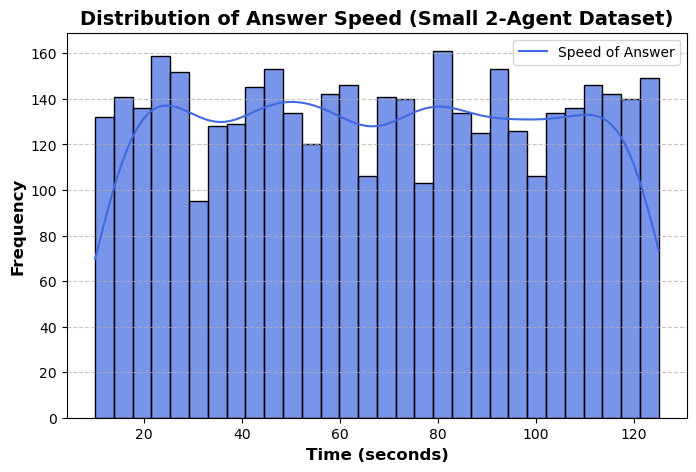

In [ ]:
def analyze_data(df, dataset_name):
    """优化后的数据分析 + 直方图"""
    print(f"\nAnalysis for {dataset_name}:")
    print(df.describe())

    plt.figure(figsize=(8, 5))
    sns.histplot(df['Speed of answer in seconds'].dropna(), bins=30, kde=True, color="royalblue", alpha=0.7)

    plt.xlabel("Time (seconds)", fontsize=12, fontweight='bold')
    plt.ylabel("Frequency", fontsize=12, fontweight='bold')
    plt.title(f"Distribution of Answer Speed ({dataset_name})", fontsize=14, fontweight='bold')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(["Speed of Answer"], loc="upper right")
    plt.show()
    
analyze_data(df2, "Small 2-Agent Dataset")



Index(['Call Id', 'Agent', 'Date', 'Time', 'Topic', 'Answered (Y/N)',
       'Resolved', 'Speed of answer in seconds', 'AvgTalkDuration',
       'Satisfaction rating', 'Dataset'],
      dtype='object')


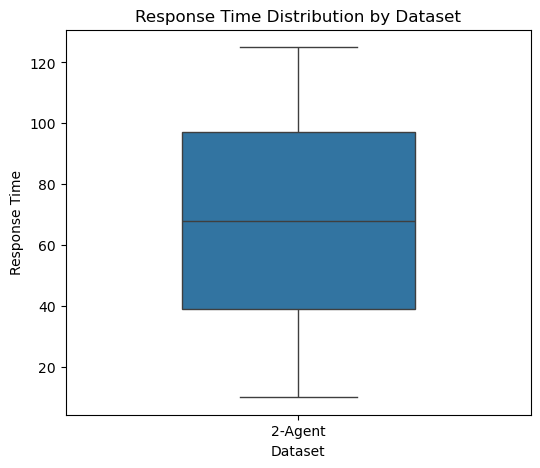

In [ ]:
#boxplot
df2["Dataset"] = "2-Agent"

plt.figure(figsize=(6, 5))
print(df2.columns)

sns.boxplot(data=df2, x="Dataset", y="Speed of answer in seconds", width=0.5)
plt.xlabel("Dataset")
plt.ylabel("Response Time")
plt.title("Response Time Distribution by Dataset")
plt.show()

In [ ]:
# Define MDP Model
def create_mdp_model():
    """Define MDP states, actions, rewards."""
    states = ["idle", "handling_call", "waiting"]
    actions = ["assign_agent", "queue_call", "reject_call"]
    
    transition_matrix = np.array([
        [0.7, 0.2, 0.1],  
        [0.3, 0.6, 0.1],  
        [0.2, 0.3, 0.5]  
    ])
    
    
    rewards = np.array([-1, 5, -2]) 
    
    return states, actions, transition_matrix, rewards

# Solve MDP using ADP
def solve_mdp_adp(transition_matrix, rewards, discount_factor=0.9, iterations=1000):
    """Use value iteration to solve MDP."""
    num_states = len(rewards)
    value_function = np.zeros(num_states)

    for _ in range(iterations):
        
        q_values = rewards + discount_factor * np.dot(transition_matrix, value_function)
        new_value_function = np.max(q_values, axis=0)

        
        if np.allclose(new_value_function, value_function, atol=1e-4):
            break
        value_function = new_value_function

    return value_function


states, actions, transition_matrix, rewards = create_mdp_model()
optimal_values = solve_mdp_adp(transition_matrix, rewards)

print("Optimal Value Function:", optimal_values)


Optimal Value Function: [ 8.17537164 12.86460426  4.55383688]


C:\Users\jerry\AppData\Local\Temp\ipykernel_25972\3893498532.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=states, y=optimal_values, palette="Blues")


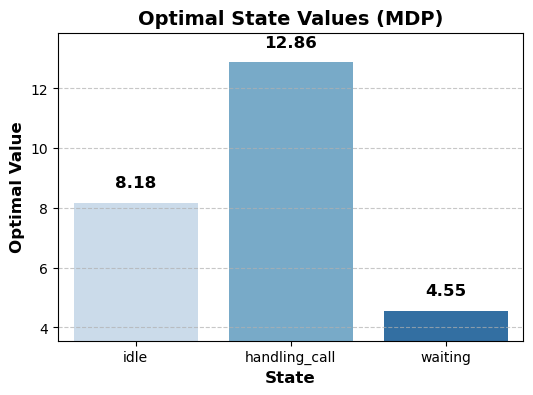

In [ ]:
# Plot Optimal State Values
plt.figure(figsize=(6, 4))
sns.barplot(x=states, y=optimal_values, palette="Blues")
plt.xlabel("State", fontsize=12, fontweight='bold')
plt.ylabel("Optimal Value", fontsize=12, fontweight='bold')
plt.title("Optimal State Values (MDP)", fontsize=14, fontweight='bold')

for i, v in enumerate(optimal_values):
    plt.text(i, v + 0.05 * (max(optimal_values) - min(optimal_values)), f"{v:.2f}", 
             ha="center", va="bottom", fontsize=12, color="black", fontweight="bold")

plt.grid(axis="y", linestyle="--", alpha=0.7) 
plt.ylim(min(optimal_values) - 1, max(optimal_values) + 1) 
plt.show()



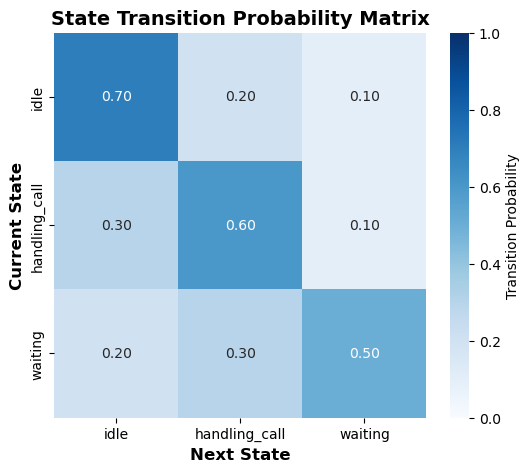

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(transition_matrix, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=states, yticklabels=states, cbar_kws={"label": "Transition Probability"})

plt.xlabel("Next State", fontsize=12, fontweight='bold')
plt.ylabel("Current State", fontsize=12, fontweight='bold')
plt.title("State Transition Probability Matrix", fontsize=14, fontweight='bold')
plt.show()

Training PPO on Small 2-Agent Dataset...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


d:\Anaconda\envs\rl_env\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 772  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 607         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011497896 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_variance   | -0.0128     |
|    learning_rate        | 0.0003      |
|    loss                 | 208         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0246     |
|    value_loss           | 708         |
-----------------------------------------
----------------------------------

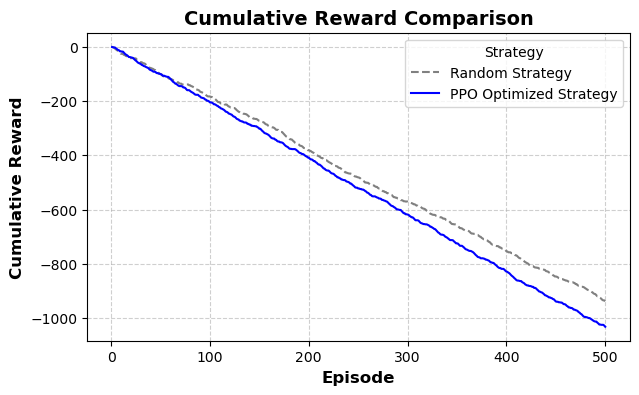

In [ ]:
class CallCenterEnv(gym.Env):
    def __init__(self, num_agents=8, num_call_types=5):
        super(CallCenterEnv, self).__init__()
        self.num_agents = num_agents
        self.num_call_types = num_call_types
        self.observation_space = spaces.Box(low=0, high=10, shape=(num_call_types,), dtype=np.int32)
        self.action_space = spaces.Discrete(num_agents)
        self.state = np.zeros(num_call_types)

    def reset(self, seed=None, options=None):
        self.state = np.random.randint(0, 5, size=(self.num_call_types,))
        return self.state, {}

    def step(self, action):
        reward = -self.state[action] 
        self.state = np.random.randint(0, 5, size=(self.num_call_types,))
        done = False
        return self.state, reward, done, False, {}

def train_ppo(env, timesteps, dataset_name):
    print(f"Training PPO on {dataset_name}...")
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=timesteps)
    print(f"Training completed for {dataset_name}.")
    return model

env_small = CallCenterEnv(num_agents=2, num_call_types=3)
ppo_model_small = train_ppo(env_small, timesteps=5000, dataset_name="Small 2-Agent Dataset")

random_rewards = []
optimal_rewards = []

obs, _ = env_small.reset()
for episode in range(500):
    random_action = env_small.action_space.sample()  
    optimal_action, _ = ppo_model_small.predict(obs)  

    
    _, random_reward, _, _, _ = env_small.step(random_action)
    _, optimal_reward, _, _, _ = env_small.step(optimal_action)


    if episode == 0:
        random_rewards.append(random_reward)
        optimal_rewards.append(optimal_reward)
    else:
        random_rewards.append(random_rewards[-1] + random_reward)
        optimal_rewards.append(optimal_rewards[-1] + optimal_reward)


episodes = np.arange(1, 501)


plt.figure(figsize=(7, 4))


plt.plot(episodes, random_rewards, label="Random Strategy", color="gray", linestyle="--")


plt.plot(episodes, optimal_rewards, label="PPO Optimized Strategy", color="blue")


plt.xlabel("Episode", fontsize=12, fontweight='bold')
plt.ylabel("Cumulative Reward", fontsize=12, fontweight='bold')
plt.title("Cumulative Reward Comparison", fontsize=14, fontweight='bold')
plt.legend(title="Strategy")


plt.grid(alpha=0.6, linestyle="--")


plt.show()